### Author: Ryuta Kawano (National Institute of Informatics)

# 4-qumode classifier

Classical and Continuous Variable Quantum hybrid network: Classical layers using keras dense and quantum layers using Pennylane

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets, transforms

import pennylane as qml
import numpy as np
import random

import matplotlib.pyplot as plt

## 0. Loading data

In [2]:
cutoff_dim = 2
num_modes = 4

# FOR EVAL
n_train = 600
n_test = 100
batch_size = 10
num_epochs = 100

# # FOR TEST
# n_train = 30
# n_test = 10
# batch_size = 1
# num_epochs = 50

rand_seed = 2

torch.set_default_dtype(torch.float64)

qweight_scale = 0.3

n_rwqnn = 5
n_inserts = 8

learning_rate = 0.2

In [3]:
import os

def get_train_sampler(len_train, n_train, g):
    if not os.path.isdir("./pths"):
        os.makedirs("./pths")

    train_indices_pth = f"./pths/train_l{len_train}n{n_train}.pth"
    if os.path.exists(train_indices_pth):
        subsample_train_indices = torch.load(train_indices_pth)
    else:
        subsample_train_indices = torch.randperm(len_train, generator=g)[:n_train]
        torch.save(subsample_train_indices, train_indices_pth)

    return torch.utils.data.SubsetRandomSampler(subsample_train_indices, generator=g)

def get_test_sampler(len_test, n_test, g):
    if not os.path.isdir("./pths"):
        os.path.makedirs("./pths")

    test_indices_pth = f"./pths/test_l{len_test}n{n_test}.pth"
    if os.path.exists(test_indices_pth):
        subsample_test_indices = torch.load(test_indices_pth)
    else:
        subsample_test_indices = torch.randperm(len_test, generator=g)[:n_test]
        torch.save(subsample_test_indices, test_indices_pth)

    return torch.utils.data.SubsetRandomSampler(subsample_test_indices, generator=g)


In [4]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

torch.manual_seed(rand_seed)
g = torch.Generator()
g.manual_seed(rand_seed)

np_rng = np.random.default_rng(seed=rand_seed)


In [5]:

# download and transform train dataset
train_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=True,
                            transform=transforms.Compose([
                                transforms.ToTensor(), # first, convert image to PyTorch tensor
                                # transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                            ]),
                            target_transform=transforms.Compose([
                                torch.tensor, # or just torch.tensor
                                lambda x:F.one_hot(x, cutoff_dim ** num_modes)
                            ]),
                            )

# download and transform test dataset
test_data = datasets.MNIST('./mnist_data', 
                            download=True, 
                            train=False,
                            transform=transforms.Compose([
                                transforms.ToTensor(), # first, convert image to PyTorch tensor
                                # transforms.Normalize((0.1307,), (0.3081,)) # normalize inputs
                            ]),
                            target_transform=transforms.Compose([
                                torch.tensor, # or just torch.tensor
                                lambda x:F.one_hot(x, cutoff_dim ** num_modes)
                            ]),
                            )

len_train = len(train_data)
len_test = len(test_data)


In [6]:

# subsample_train_indices = torch.randperm(len_train)[:n_train]
# train_sampler = torch.utils.data.SubsetRandomSampler(subsample_train_indices, generator=g)
# subsample_test_indices = torch.randperm(len_test)[:n_test]
# test_sampler = torch.utils.data.SubsetRandomSampler(subsample_test_indices, generator=g)

train_sampler = get_train_sampler(len_train, n_train, g)
test_sampler = get_test_sampler(len_test, n_test, g)

train_loader = torch.utils.data.DataLoader(train_data, 
                                           batch_size=batch_size, 
                                        #    shuffle=True,
                                           worker_init_fn=seed_worker,
                                           generator=g,
                                           sampler = train_sampler,
                                           )
test_loader = torch.utils.data.DataLoader(test_data, 
                                           batch_size=batch_size, 
                                        #    shuffle=True,
                                           worker_init_fn=seed_worker,
                                           generator=g,
                                           sampler = test_sampler,
                                           )


In [7]:
# for x, y in train_loader:
#     print(x)
#     print(y)
#     break
# print(len(train_loader))


One hot encode labels to vectors of size cutoff_dim^(num_modes)

## 1. Classical circuit

Define classical layers using Keras Sequential. Take in 28x28 image matrices, flatten, and output vectors of length 30. 2 hidden layers with ELU activation.

In [8]:
class Clayer_q4(nn.Module):
    def __init__(self):
        super(Clayer_q4, self).__init__()

        self.model = nn.Sequential(
            nn.Flatten(), # 10x28x28 -> 10x784

            # nn.Linear(784, 392),
            # nn.ELU(),
            # nn.Linear(392, 196),
            # nn.ELU(),
            # nn.Linear(196, 98),
            # nn.Linear(98, 49),
            # nn.ELU(),
            # nn.Linear(49, 30),
            nn.Linear(784, 392),
            nn.AdaptiveAvgPool1d(30),
            nn.ELU(),
        )

    def forward(self, x):
        x = self.model(x)
        return x


In [9]:
print("Clayer_q4")
x = torch.rand(10, 28, 28)
print(x.size())
net = Clayer_q4()
y = net(x)
print(y.size())

print(x)
print(y)

Clayer_q4
torch.Size([10, 28, 28])
torch.Size([10, 30])
tensor([[[0.9176, 0.0969, 0.7088,  ..., 0.1344, 0.8726, 0.0248],
         [0.1871, 0.4442, 0.0288,  ..., 0.5418, 0.0513, 0.7104],
         [0.2190, 0.5117, 0.4089,  ..., 0.3283, 0.1897, 0.6480],
         ...,
         [0.6809, 0.1135, 0.0089,  ..., 0.8128, 0.1878, 0.8577],
         [0.3886, 0.4812, 0.0772,  ..., 0.0477, 0.6266, 0.5245],
         [0.1029, 0.0224, 0.7265,  ..., 0.8298, 0.8178, 0.0854]],

        [[0.7088, 0.6388, 0.0373,  ..., 0.4566, 0.9867, 0.9093],
         [0.9258, 0.1480, 0.4093,  ..., 0.2610, 0.8857, 0.7036],
         [0.5346, 0.5653, 0.4994,  ..., 0.2833, 0.8697, 0.0143],
         ...,
         [0.0918, 0.8664, 0.7235,  ..., 0.0359, 0.5663, 0.3640],
         [0.2849, 0.2145, 0.5419,  ..., 0.2030, 0.1833, 0.7212],
         [0.6789, 0.1025, 0.2416,  ..., 0.7857, 0.3725, 0.5495]],

        [[0.0633, 0.9992, 0.2530,  ..., 0.2428, 0.0713, 0.4133],
         [0.3813, 0.7593, 0.2427,  ..., 0.2118, 0.8721, 0.9405],
  

## 2. Data encoding circuit

Encode the output vectors from the classical network into quantum states using the vector entries as parameters of continuous variable gates. 

In [10]:
def encode_data(x):
    qml.Squeezing(x[0], x[1], wires=0)
    qml.Squeezing(x[2], x[3], wires=1)
    qml.Squeezing(x[4], x[5], wires=2)
    qml.Squeezing(x[6], x[7], wires=3)
    
    qml.Beamsplitter(x[8], x[9], wires=[0,1])
    qml.Beamsplitter(x[10], x[11], wires=[1,2])
    qml.Beamsplitter(x[12], x[13], wires=[2,3])
    
    qml.Rotation(x[14], wires=0)
    qml.Rotation(x[15], wires=1)
    qml.Rotation(x[16], wires=2)
    qml.Rotation(x[17], wires=3)    
    
    qml.Displacement(x[18], x[19], wires=0)
    qml.Displacement(x[20], x[21], wires=1)
    qml.Displacement(x[22], x[23], wires=2)
    qml.Displacement(x[24], x[25], wires=3) 
    
    qml.Kerr(x[26], wires=0)
    qml.Kerr(x[27], wires=1)
    qml.Kerr(x[28], wires=2)
    qml.Kerr(x[29], wires=3)

## 3. Qauntum neural network layers

### 3.1 layer for 4 modes

In [11]:
def layer(v):
    
    # Linear transformation W = Interferemeter, squeezers, interferometer
    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[0,1])
    qml.Beamsplitter(v[2], v[3], wires=[1,2])
    qml.Beamsplitter(v[4], v[5], wires=[2,3])
    
    qml.Rotation(v[6], wires=0)
    qml.Rotation(v[7], wires=1)
    qml.Rotation(v[8], wires=2)
    qml.Rotation(v[9], wires=3)
    
    # Squeezers
    qml.Squeezing(v[10], 0.0, wires=0)
    qml.Squeezing(v[11], 0.0, wires=1)
    qml.Squeezing(v[12], 0.0, wires=2)
    qml.Squeezing(v[13], 0.0, wires=3) 
    
    # Interferometer 2
    qml.Beamsplitter(v[14], v[15], wires=[0,1])
    qml.Beamsplitter(v[16], v[17], wires=[1,2])
    qml.Beamsplitter(v[18], v[19], wires=[2,3])
    
    qml.Rotation(v[20], wires=0)
    qml.Rotation(v[21], wires=1)
    qml.Rotation(v[22], wires=2)
    qml.Rotation(v[23], wires=3)
    
    # Bias addition
    qml.Displacement(v[24], 0.0, wires=0)
    qml.Displacement(v[25], 0.0, wires=1)
    qml.Displacement(v[26], 0.0, wires=2)
    qml.Displacement(v[27], 0.0, wires=3)
    
    # Non-linear activation
    qml.Kerr(v[28], wires=0)
    qml.Kerr(v[29], wires=1)
    qml.Kerr(v[30], wires=2)
    qml.Kerr(v[31], wires=3)

### 3.2 layer for 2 modes

In [12]:
def qnn_layer_m2(v, wires):

    # Interferometer 1
    qml.Beamsplitter(v[0], v[1], wires=[wires[0],wires[1]])
    qml.Rotation(v[2], wires=wires[0])
    qml.Rotation(v[3], wires=wires[1])
    
    # Squeezers
    qml.Squeezing(v[4], 0.0, wires=wires[0])
    qml.Squeezing(v[5], 0.0, wires=wires[1])
    
    # Interferometer 2
    qml.Beamsplitter(v[6], v[7], wires=[wires[0],wires[1]])
    qml.Rotation(v[8], wires=wires[0])
    qml.Rotation(v[9], wires=wires[1])
    
    # Bias addition
    qml.Displacement(v[10], 0.0, wires=wires[0])
    qml.Displacement(v[11], 0.0, wires=wires[1])
    
    # Non-linear activation function
    qml.Kerr(v[12], wires=wires[0])
    qml.Kerr(v[13], wires=wires[1])

    # # Interferometer 1
    # qml.Beamsplitter(v[0], v[1], wires=[0,1])
    # qml.Rotation(v[2], wires=0)
    # qml.Rotation(v[3], wires=1)
    
    # # Squeezers
    # qml.Squeezing(v[4], 0.0, wires=0)
    # qml.Squeezing(v[5], 0.0, wires=1)
    
    # # Interferometer 2
    # qml.Beamsplitter(v[6], v[7], wires=[0,1])
    # qml.Rotation(v[8], wires=0)
    # qml.Rotation(v[9], wires=1)
    
    # # Bias addition
    # qml.Displacement(v[10], 0.0, wires=0)
    # qml.Displacement(v[11], 0.0, wires=1)
    
    # # Non-linear activation function
    # qml.Kerr(v[12], wires=0)
    # qml.Kerr(v[13], wires=1)
    

## 4. Hybrid Circuit

### 4.1 Circuit for 4 modes

For the expression of qumodes in Fock basis, choose a "strawberryfields.fock" device. Define the number of qumodes and cutoff dimension. Run the data encoding circuit and quantum neural network circuit. The probability measurement method (qml.probs(wires)) returns vectors of size 2^4 = 16 (cutoff_dim^num_modes).

### 4.1.1 quantum device for 4 modes

In [13]:
# select a device 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev)
def quantum_nn_m4(inputs, var):
    # Encode input x into quantum state
    encode_data(inputs)

    # iterative quantum layers
    for i, v in enumerate(var):
        layer(v)

    return qml.probs(wires=[0, 1, 2, 3])  # Measurement

### 4.1.2 hybrid circuit for 4 modes

In [14]:
num_layers = 4
num_params = 32
weight_shape = {'var': (num_layers, num_params)} # 4 layers and 32 parameters per layer
qlayer_m4 = qml.qnn.TorchLayer(quantum_nn_m4, weight_shape, init_method=lambda x: torch.nn.init.uniform_(x, a=qweight_scale * -1, b=qweight_scale))

In [15]:
class HybridCircuit_m4(nn.Module):
    def __init__(self) -> None:
        super(HybridCircuit_m4, self).__init__()

        self.model = nn.Sequential(
            Clayer_q4(),
            qlayer_m4,
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [16]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("HybridCircuit_m4")
x = torch.rand(10, 28, 28)
print(x.size())
net = HybridCircuit_m4()
x, net = x.to(device), net.to(device)
y = net(x)
print(y.size())

# print(x)
# print(y)
print(y[0])
print(sum(y[0]))
print(torch.mean(y[:,7]))

HybridCircuit_m4
torch.Size([10, 28, 28])
torch.Size([10, 16])
tensor([3.8414e-01, 5.9294e-02, 8.4098e-03, 2.3011e-04, 1.6850e-01, 2.1996e-02,
        8.9737e-03, 2.4795e-04, 2.9112e-02, 4.9193e-03, 8.7633e-05, 9.2700e-06,
        2.4864e-02, 3.2847e-03, 1.2341e-03, 3.3656e-05], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0.7153, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0003, device='cuda:0', grad_fn=<MeanBackward0>)


### 4.2 RWQNN Circuit for 2 modes

### 4.2.0 generate random inserts for RWQNN

In [17]:
def gen_inserts(n_modes, n_inserts, g: np.random.Generator, id: int):
    if not os.path.isdir("./pths/inserts"):
        os.makedirs("./pths/inserts")
    
    inserts_pth = f"./pths/inserts/inserts_m{n_modes}i{n_inserts}_{id}.pth"

    if os.path.exists(inserts_pth):
        insert_modes = torch.load(inserts_pth)
    else:
        insert_modes = list()
        for _ in range(n_inserts):
            insert_modes.append(sorted(list(g.choice(n_modes, 2, replace=False))))

        torch.save(insert_modes, inserts_pth)

    return insert_modes

### 4.2.1 quantum layers for 2 modes

In [18]:
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim)

qlayers_m2 = list()

for rwqnn_id in range(n_rwqnn):
    insert_modes = gen_inserts(num_modes, n_inserts, np_rng, rwqnn_id)
    print(rwqnn_id, insert_modes)

    @qml.qnode(dev)
    def quantum_nn_m2(inputs, var):
        # Encode input x into quantum state
        encode_data(inputs)

        # iterative quantum layers
        for i, v in enumerate(var):
            qnn_layer_m2(v, insert_modes[i])

        return qml.probs(wires=[0, 1, 2, 3])  # Measurement
    
    num_layers = 8
    num_params = 14
    weight_shape = {'var': (num_layers, num_params)} # 4 layers and 32 
    qlayer = qml.qnn.TorchLayer(quantum_nn_m2, weight_shape, init_method=lambda x: torch.nn.init.uniform_(x, a=qweight_scale * -1, b=qweight_scale))

    qlayers_m2.append(qlayer)


0 [[1, 2], [0, 1], [0, 1], [1, 3], [0, 2], [0, 2], [0, 2], [1, 3]]
1 [[1, 2], [0, 1], [0, 1], [1, 3], [0, 2], [0, 2], [0, 2], [1, 3]]
2 [[1, 2], [2, 3], [0, 2], [2, 3], [1, 3], [0, 1], [1, 2], [2, 3]]
3 [[1, 2], [0, 2], [1, 2], [0, 1], [0, 2], [2, 3], [1, 3], [1, 3]]
4 [[1, 2], [1, 3], [0, 1], [1, 2], [0, 3], [0, 1], [1, 3], [0, 1]]


In [19]:
class HybridCircuit_m2(nn.Module):
    def __init__(self, qlayer) -> None:
        super(HybridCircuit_m2, self).__init__()
        self.qlayer = qlayer

        self.model = nn.Sequential(
            Clayer_q4(),
            self.qlayer,
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [20]:
m2_id = 0

# device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("HybridCircuit_m2")
x = torch.rand(10, 28, 28)
print(x.size())
net = HybridCircuit_m2(qlayers_m2[m2_id])
x, net = x.to(device), net.to(device)
y = net(x)
print(y.size())

# print(x)
# print(y)
print(y[0])
print(sum(y[0]))
print(torch.mean(y[:,7]))

HybridCircuit_m2
torch.Size([10, 28, 28])
torch.Size([10, 16])
tensor([5.3495e-01, 6.9900e-03, 2.6608e-02, 3.4985e-04, 3.0879e-02, 4.9132e-04,
        1.6606e-03, 2.6068e-05, 1.2573e-01, 1.6204e-03, 6.2649e-03, 8.1753e-05,
        5.7812e-03, 9.2437e-05, 3.1129e-04, 4.9429e-06], device='cuda:0',
       grad_fn=<SelectBackward0>)
tensor(0.7418, device='cuda:0', grad_fn=<AddBackward0>)
tensor(2.9204e-05, device='cuda:0', grad_fn=<MeanBackward0>)


### 4.3 AvgPool Circuit (for comparison)

In [21]:
class Qlayer_dummy_AvgPool(nn.Module):
    def __init__(self) -> None:
        super(Qlayer_dummy_AvgPool, self).__init__()

        self.model = nn.Sequential(
            nn.AdaptiveAvgPool1d(16)
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [22]:
class HybridCircuit_dummy(nn.Module):
    def __init__(self) -> None:
        super(HybridCircuit_dummy, self).__init__()

        self.model = nn.Sequential(
            Clayer_q4(),
            Qlayer_dummy_AvgPool(),
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [23]:
print("HybridCircuit_dummy")
x = torch.rand(10, 28, 28)
print(x.size())
net = HybridCircuit_dummy()
x, net = x.to(device), net.to(device)
y = net(x)
print(y.size())

# print(x)
# print(y)
print(y[0])
print(sum(y[0]))
print(torch.mean(y[:,7]))

HybridCircuit_dummy
torch.Size([10, 28, 28])
torch.Size([10, 16])
tensor([-0.0201,  0.0871, -0.0489, -0.0560,  0.0172,  0.0288,  0.0102,  0.0045,
        -0.0238,  0.0346,  0.0351, -0.0537, -0.0818, -0.0126, -0.0153,  0.1097],
       device='cuda:0', grad_fn=<SelectBackward0>)
tensor(0.0150, device='cuda:0', grad_fn=<AddBackward0>)
tensor(0.0301, device='cuda:0', grad_fn=<MeanBackward0>)


### 4.4 empty circuit (for comparison)

In [24]:
# select a device 
dev = qml.device("strawberryfields.fock", wires=num_modes, cutoff_dim=cutoff_dim) 

@qml.qnode(dev)
def quantum_nn_m4_empty(inputs, var):
    # Encode input x into quantum state
    encode_data(inputs)

    return qml.probs(wires=[0, 1, 2, 3])  # Measurement

In [25]:
weight_shape = {'var': (0, 0)}
qlayer_m4_empty = qml.qnn.TorchLayer(quantum_nn_m4_empty, weight_shape, init_method=lambda x: torch.nn.init.uniform_(x, a=qweight_scale * -1, b=qweight_scale))

In [26]:
class HybridCircuit_m4_empty(nn.Module):
    def __init__(self) -> None:
        super(HybridCircuit_m4_empty, self).__init__()

        self.model = nn.Sequential(
            Clayer_q4(),
            qlayer_m4_empty,
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [27]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print("HybridCircuit_m4_empty")
x = torch.rand(10, 28, 28)
# print(x.size())
net = HybridCircuit_m4_empty()
x, net = x.to(device), net.to(device)
y = net(x)
# print(y.size())

print(x)
print(y)
print(y[0])
print(sum(y[0]))
print(torch.mean(y[:,7]))

HybridCircuit_m4_empty
tensor([[[0.7883, 0.1673, 0.4496,  ..., 0.3324, 0.4163, 0.5184],
         [0.7720, 0.9364, 0.3019,  ..., 0.4844, 0.5331, 0.0914],
         [0.1526, 0.4739, 0.0185,  ..., 0.8006, 0.5116, 0.2115],
         ...,
         [0.0850, 0.4014, 0.3122,  ..., 0.5637, 0.1634, 0.8495],
         [0.3730, 0.4021, 0.7984,  ..., 0.6091, 0.9523, 0.3187],
         [0.8982, 0.8507, 0.1279,  ..., 0.2375, 0.2540, 0.6427]],

        [[0.4966, 0.7990, 0.5952,  ..., 0.3568, 0.8682, 0.0946],
         [0.5747, 0.0344, 0.0599,  ..., 0.5309, 0.3964, 0.1132],
         [0.5008, 0.9283, 0.6916,  ..., 0.6841, 0.5530, 0.3958],
         ...,
         [0.4077, 0.3031, 0.6960,  ..., 0.7137, 0.4270, 0.7840],
         [0.8899, 0.7515, 0.1569,  ..., 0.1179, 0.9834, 0.1471],
         [0.1569, 0.7526, 0.1014,  ..., 0.7181, 0.9630, 0.2383]],

        [[0.8200, 0.8827, 0.2114,  ..., 0.8501, 0.8711, 0.5162],
         [0.1921, 0.9586, 0.2291,  ..., 0.6951, 0.5365, 0.8881],
         [0.0494, 0.8276, 0.2472,  

## 5. Training

In [28]:
def criterion_c(x, y):
    log_x = torch.log_softmax(x, dim=1)
    y_label = torch.argmax(y, dim=1)
    return nn.CrossEntropyLoss()(log_x, y_label)

In [29]:
def criterion_q(x,y):
    y_label = torch.argmax(y, dim=1)
    return nn.CrossEntropyLoss()(x, y_label)


In [30]:
import torch.optim as optim

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
# device = "cpu"
print(device)


cuda:0


In [ ]:
nets_m2 = {f"m2_{i}": HybridCircuit_m2(qlayers_m2[i]) for i in range(n_rwqnn)}
nets = {"m4": HybridCircuit_m4(),
        "dummy": HybridCircuit_dummy(),
        # "empty": HybridCircuit_m4_empty(),
        }
# nets = {"dummy": HybridCircuit_dummy(),
#         }

nets.update(nets_m2)

print(nets)

In [32]:
for net_name, net in nets.items():
# for net_name, net in [["empty", nets["empty"]]]:
    print(net_name)
    chkpts_dir = f"./pths/chkpts/{net_name}"
    if not os.path.isdir(chkpts_dir):
        os.makedirs(chkpts_dir)

    net = net.to(device)

    optimizer = optim.SGD(net.parameters(), lr=learning_rate)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=num_epochs)

    if net_name == "dummy":
        criterion = criterion_c
    else:
        criterion = criterion_q
        
    for epoch in range(num_epochs):
        running_loss = 0.0
        correct = 0
        total = 0

        for i, data in enumerate(train_loader, 0):
            inputs, labels = data
            labels = labels.to(torch.float64)
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            # print(labels)
            outputs = net(inputs)

            # print(labels)
            # print(outputs)
            # print(outputs.dtype, outputs.shape)
            # print(labels.dtype, labels.shape)
            loss = criterion(outputs, labels)
            # print(loss)
            loss.backward()
            optimizer.step()

            # print statistics
            running_loss += loss.item()


            predicted = torch.argmax(outputs.data, dim=1)
            labels_y = torch.argmax(labels, dim=1)

            total += labels.size(0)
            # print(predicted, labels_y)
            correct += (predicted == labels_y).sum().item()
            
            # if i % 2000 == 1999:    # print every 2000 mini-batches
            #     print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.3f}')
            #     running_loss = 0.0
            if batch_size == 1:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.10f} acc={correct / total:.8f} predicted: {predicted.item()} labels_y: {labels_y.item()}')
            else:
                print(f'[{epoch + 1}, {i + 1:5d}] loss: {running_loss / 2000:.10f} acc={correct / total:.8f}')

        chkpt_path = f"./pths/chkpts/{net_name}/mnist_{net_name}_{(epoch+1):0=3}.pth"
        print(chkpt_path)

        torch.save(net.state_dict(), chkpt_path)

        scheduler.step()
        
    print('Finished Training')




[99,    55] loss: 0.0681530158 acc=0.70181818
[99,    56] loss: 0.0693853373 acc=0.70178571
[99,    57] loss: 0.0705816526 acc=0.70350877
[99,    58] loss: 0.0718226218 acc=0.70344828
[99,    59] loss: 0.0730280399 acc=0.70508475
[99,    60] loss: 0.0743128388 acc=0.70166667
./pths/chkpts/m2_4/mnist_m2_4_099.pth
[100,     1] loss: 0.0013037151 acc=0.50000000
[100,     2] loss: 0.0025080437 acc=0.70000000
[100,     3] loss: 0.0037203892 acc=0.73333333
[100,     4] loss: 0.0050251984 acc=0.65000000
[100,     5] loss: 0.0062619518 acc=0.62000000
[100,     6] loss: 0.0074751612 acc=0.65000000
[100,     7] loss: 0.0086844759 acc=0.67142857
[100,     8] loss: 0.0099165170 acc=0.66250000
[100,     9] loss: 0.0111418566 acc=0.67777778
[100,    10] loss: 0.0123950700 acc=0.68000000
[100,    11] loss: 0.0135888433 acc=0.70909091
[100,    12] loss: 0.0148420190 acc=0.70000000
[100,    13] loss: 0.0160498043 acc=0.70769231
[100,    14] loss: 0.0173723499 acc=0.68571429
[100,    15] loss: 0.0186505

## 6. Test

In [33]:
from collections import defaultdict as dd

def dd_to_dict(d):
    if isinstance(d, dd):
        d = {k: dd_to_dict(v) for k, v in d.items()}
    return d

rec_dd = lambda: dd(rec_dd)


In [34]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)
# device = "cpu"


cuda:0


In [35]:
loss_rec_dd = rec_dd()
acc_rec_dd = rec_dd()

for net_name, net in nets.items():
# for net_name, net in [["empty", nets["empty"]]]:
    print(net_name)
    # if (net_name == "empty"):
    #     continue
    net = net.to(device)
    net.eval()

    for epoch in range(num_epochs):
        chkpt_path = f"./pths/chkpts/{net_name}/mnist_{net_name}_{(epoch+1):0=3}.pth"
        net.load_state_dict(torch.load(chkpt_path))
        
        test_loss = 0.0
        correct = 0
        total = 0

        with torch.no_grad():
            for data in test_loader:
                inputs, labels = data
                labels = labels.to(torch.float64)
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = net(inputs)
                # print(inputs)
                # print(labels)
                # print(outputs)

                tmp_loss = criterion(outputs, labels)
                test_loss += tmp_loss.item()

                predicted = torch.argmax(outputs.data, dim=1)
                labels_y = torch.argmax(labels, dim=1)

                total += labels.size(0)
                # print(predicted, labels_y)
                correct += (predicted == labels_y).sum().item()

        # print(outputs)
        # print(predicted, labels_y)
        print(f"{epoch+1}\tloss={test_loss / total:.8f}\tacc={correct / total:.8f}")

        loss_rec_dd[net_name][epoch+1] = test_loss / total
        acc_rec_dd[net_name][epoch+1] = correct / total

# print(loss_rec_dd)
# print(acc_rec_dd)


m4
1	loss=0.26307875	acc=0.33000000
2	loss=0.25881153	acc=0.38000000
3	loss=0.25727052	acc=0.44000000
4	loss=0.25588169	acc=0.51000000
5	loss=0.25534688	acc=0.48000000
6	loss=0.25497811	acc=0.51000000
7	loss=0.25466232	acc=0.51000000
8	loss=0.25409854	acc=0.51000000
9	loss=0.25497378	acc=0.49000000
10	loss=0.25481703	acc=0.51000000
11	loss=0.25603356	acc=0.55000000
12	loss=0.25487163	acc=0.51000000
13	loss=0.25406954	acc=0.56000000
14	loss=0.25388587	acc=0.57000000
15	loss=0.25346042	acc=0.57000000
16	loss=0.25386560	acc=0.55000000
17	loss=0.25405229	acc=0.57000000
18	loss=0.25339912	acc=0.56000000
19	loss=0.25368044	acc=0.57000000
20	loss=0.25345500	acc=0.57000000
21	loss=0.25365140	acc=0.59000000
22	loss=0.25365122	acc=0.58000000
23	loss=0.25396524	acc=0.60000000
24	loss=0.25381729	acc=0.58000000
25	loss=0.25567415	acc=0.58000000
26	loss=0.25351929	acc=0.61000000
27	loss=0.25377511	acc=0.63000000
28	loss=0.25409224	acc=0.60000000
29	loss=0.25405674	acc=0.61000000
30	loss=0.25404115	a

## 7. Plot

In [81]:
loss_dict = dd_to_dict(loss_rec_dd)
acc_dict = dd_to_dict(acc_rec_dd)

print(loss_dict, acc_dict)
rows = list(sorted(loss_dict.keys()))
print(rows)

pd_data_columns = list(range(1, num_epochs+1))

loss_data = {k: [loss_dict[k][e] for e in pd_data_columns] for k in rows}
acc_data = {k: [acc_dict[k][e] for e in pd_data_columns] for k in rows}

epochs_dict = {"epoch": [k+1 for k in range(num_epochs)]}
loss_data.update(epochs_dict)
acc_data.update(epochs_dict)

{'m4': {1: 0.2630787485491826, 2: 0.25881153491444303, 3: 0.25727051616218977, 4: 0.2558816940491246, 5: 0.25534687698162545, 6: 0.2549781063142412, 7: 0.2546623221535548, 8: 0.25409853688472833, 9: 0.254973778510584, 10: 0.2548170259696101, 11: 0.2560335584779166, 12: 0.25487162949066916, 13: 0.25406954071479015, 14: 0.2538858659347645, 15: 0.2534604243702628, 16: 0.25386560251608703, 17: 0.2540522892878979, 18: 0.2533991239870307, 19: 0.2536804406322111, 20: 0.253454999335797, 21: 0.25365139662476877, 22: 0.25365121699904397, 23: 0.25396524289369293, 24: 0.2538172889695061, 25: 0.2556741458475421, 26: 0.25351929057683475, 27: 0.25377511011093834, 28: 0.25409224101195893, 29: 0.2540567402688214, 30: 0.2540411465907695, 31: 0.2541602605765444, 32: 0.2545652208303166, 33: 0.2543355981530792, 34: 0.2545784804160069, 35: 0.25399303343821183, 36: 0.2544686437274369, 37: 0.2541541723507482, 38: 0.2549294166238413, 39: 0.25420367861305837, 40: 0.25366502240476285, 41: 0.25364106675993625, 42

In [82]:
import pandas as pd

df_loss = pd.DataFrame.from_dict(loss_data)
df_acc = pd.DataFrame.from_dict(acc_data)

df_loss.set_index("epoch", inplace=True)
df_acc.set_index("epoch", inplace=True)

print(df_loss)
print(df_acc)

print(df_acc.max())

          dummy      m2_0      m2_1      m2_2      m2_3      m2_4        m4
epoch                                                                      
1      0.226916  0.269406  0.265780  0.265063  0.268105  0.268183  0.263079
2      0.199299  0.262552  0.257592  0.259367  0.261873  0.261898  0.258812
3      0.178977  0.261343  0.255770  0.255983  0.258956  0.257588  0.257271
4      0.162475  0.257409  0.254847  0.255376  0.257288  0.256223  0.255882
5      0.150609  0.256069  0.254704  0.254713  0.258345  0.255527  0.255347
...         ...       ...       ...       ...       ...       ...       ...
96     0.061315  0.253098  0.253038  0.253394  0.254279  0.252964  0.253749
97     0.061313  0.253097  0.253036  0.253394  0.254282  0.252964  0.253748
98     0.061313  0.253096  0.253037  0.253394  0.254283  0.252965  0.253748
99     0.061312  0.253096  0.253037  0.253394  0.254283  0.252965  0.253748
100    0.061312  0.253096  0.253037  0.253394  0.254283  0.252965  0.253748

[100 rows x

In [83]:
df_loss_m2 = df_loss.loc[:, [f"m2_{i}" for i in range(n_rwqnn)]]
df_acc_m2 = df_acc.loc[:, [f"m2_{i}" for i in range(n_rwqnn)]]

print(df_loss_m2)
print(df_acc_m2)


           m2_0      m2_1      m2_2      m2_3      m2_4
epoch                                                  
1      0.269406  0.265780  0.265063  0.268105  0.268183
2      0.262552  0.257592  0.259367  0.261873  0.261898
3      0.261343  0.255770  0.255983  0.258956  0.257588
4      0.257409  0.254847  0.255376  0.257288  0.256223
5      0.256069  0.254704  0.254713  0.258345  0.255527
...         ...       ...       ...       ...       ...
96     0.253098  0.253038  0.253394  0.254279  0.252964
97     0.253097  0.253036  0.253394  0.254282  0.252964
98     0.253096  0.253037  0.253394  0.254283  0.252965
99     0.253096  0.253037  0.253394  0.254283  0.252965
100    0.253096  0.253037  0.253394  0.254283  0.252965

[100 rows x 5 columns]
       m2_0  m2_1  m2_2  m2_3  m2_4
epoch                              
1      0.22  0.19  0.25  0.23  0.11
2      0.37  0.47  0.41  0.33  0.35
3      0.36  0.55  0.45  0.44  0.46
4      0.40  0.50  0.53  0.48  0.50
5      0.49  0.53  0.54  0.52  0

In [84]:
m2_best = df_acc_m2.loc[num_epochs].idxmax()
print(m2_best)

loss_m2_mean = df_loss_m2.mean(axis="columns")
loss_m2_std = df_loss_m2.std(axis="columns")
acc_m2_mean = df_acc_m2.mean(axis="columns")
acc_m2_std = df_acc_m2.std(axis="columns")

# print(loss_m2_mean)
# print(loss_m2_std)



m2_0


In [85]:
def set_rcparams():

    plt.rcParams.update(plt.rcParamsDefault)

    # plt.rcParams["font.size"] = 48
    plt.rcParams["figure.figsize"] = [10.0, 2.5]
    plt.rcParams["lines.linewidth"] = 1.0
    plt.rcParams["lines.markeredgewidth"] = 1.0
    plt.rcParams['lines.markersize'] = 3.0
    plt.rcParams["axes.linewidth"] = 1.0
    plt.rcParams["legend.edgecolor"] = "black"
    plt.rcParams["legend.facecolor"] = "white"
    plt.rcParams["legend.framealpha"] = 1.0
    plt.rcParams["legend.labelspacing"] = 0.05
    plt.rcParams["axes.grid"] = True

    for tick in ["xtick", "ytick"]:
        plt.rcParams[tick + ".direction"] = "in"
        plt.rcParams[tick + ".major.width"] = 1.0
        plt.rcParams[tick + ".major.size"] = 5.0
    plt.rcParams["savefig.bbox"] = "tight"
    # plt.rcParams["legend.loc"] = "bottom right"

    plt.rcParams['pdf.fonttype'] = 42
    plt.rcParams['ps.fonttype'] = 42

    plt.rcParams["font.family"] = ["Times New Roman"]

set_rcparams()

fmts_orig = ["->", "--^", "-.v", ":s", "--o"]
num_cmaps = 8
cmap_orig = [plt.get_cmap("Dark2")(c+1) for c in range(num_cmaps)]
print(cmap_orig)

import itertools as it


[(0.8509803921568627, 0.37254901960784315, 0.00784313725490196, 1.0), (0.4588235294117647, 0.4392156862745098, 0.7019607843137254, 1.0), (0.9058823529411765, 0.1607843137254902, 0.5411764705882353, 1.0), (0.4, 0.6509803921568628, 0.11764705882352941, 1.0), (0.9019607843137255, 0.6705882352941176, 0.00784313725490196, 1.0), (0.6509803921568628, 0.4627450980392157, 0.11372549019607843, 1.0), (0.4, 0.4, 0.4, 1.0), (0.4, 0.4, 0.4, 1.0)]


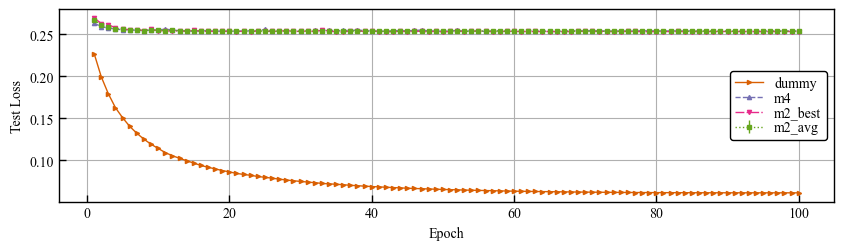

In [86]:
# dummy, m4, m2_best, m2_avg(mean, std)
fmts = it.cycle(fmts_orig)
cmap = it.cycle(cmap_orig)

fig, ax = plt.subplots()

ax_x = list(range(1,num_epochs+1))
ax.plot(ax_x, df_loss.loc[:, "dummy"], next(fmts), label="dummy", color=next(cmap))
ax.plot(ax_x, df_loss.loc[:, "m4"], next(fmts), label="m4", color=next(cmap))
ax.plot(ax_x, df_loss.loc[:, m2_best], next(fmts), label="m2_best", color=next(cmap))
ax.errorbar(x=ax_x, y=loss_m2_mean, yerr=loss_m2_std, label="m2_avg", fmt=next(fmts), color=next(cmap))

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Loss")

fig.savefig("test_loss.eps")
plt.show()


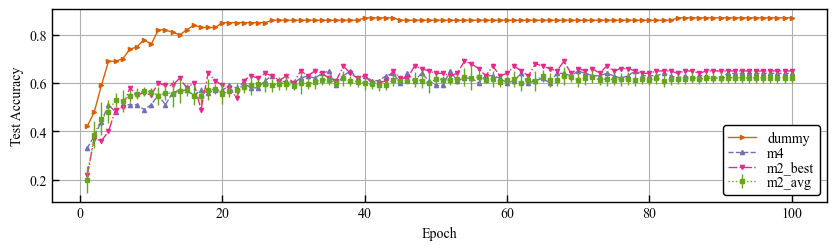

In [87]:
# dummy, m4, m2_best, m2_avg(mean, std)
fmts = it.cycle(fmts_orig)
cmap = it.cycle(cmap_orig)

fig, ax = plt.subplots()

ax_x = list(range(1,num_epochs+1))
ax.plot(ax_x, df_acc.loc[:, "dummy"], next(fmts), label="dummy", color=next(cmap))
ax.plot(ax_x, df_acc.loc[:, "m4"], next(fmts), label="m4", color=next(cmap))
ax.plot(ax_x, df_acc.loc[:, m2_best], next(fmts), label="m2_best", color=next(cmap))
ax.errorbar(x=ax_x, y=acc_m2_mean, yerr=acc_m2_std, label="m2_avg", fmt=next(fmts), color=next(cmap))

ax.legend()
ax.set_xlabel("Epoch")
ax.set_ylabel("Test Accuracy")

fig.savefig("test_acc.eps")
plt.show()


In [70]:
print(quantum_nn_m4)
# print(dir(quantum_nn_m4))
print(qml.QNode.get_best_method(quantum_nn_m4.device, quantum_nn_m4.interface))
transform = qml.QNode.get_best_method(quantum_nn_m4.device, quantum_nn_m4.interface)[0]
print(transform)
print(qml.gradients.param_shift, qml.gradients.param_shift_cv)
print(transform == qml.gradients.param_shift)
print(transform == qml.gradients.param_shift_cv)


<QNode: wires=4, device='strawberryfields.fock', interface='torch', diff_method='best'>
(<class 'pennylane.tape.cv_param_shift.CVParamShiftTape'>, 'torch', <StrawberryFieldsFock device (wires=4, shots=None) at 0x7fbb436fe790>, {'method': 'best'})
<class 'pennylane.tape.cv_param_shift.CVParamShiftTape'>
<function param_shift at 0x7fbb48fc6c10> <function param_shift_cv at 0x7fbb48fd1160>
False
False
